<!DOCTYPE html>
<html>
<head>
<style>
    .header-banner {
        background-color: white;
        color: black; 
        padding: 1rem; 
        font-family: 'Nunito', sans-serif;
    }
    .header-content {
        max-width: 2000px;
        margin: 0 auto;
        display: flex;
        align-items: center;
        gap: 2rem;
    }
    .logo {
        max-width: 160px;
    }
    .text-content {
        flex: 1;
    }
    .text-content h1 {
        font-size: 34px;
        margin: 0 0 10px;
        font-weight: 700;
        color: #7e4d02ff;
        border-bottom: 2px solid #e5c120ff;
        padding-bottom: 10px;
    }
    .text-content h2 {
        font-size: 21px;
        margin: 0 0 5px;
        font-weight: 600;
        color: #222;
    }
    .member-list {
        display: grid;
        grid-template-columns: repeat(2, auto);
        gap: 6px 40px;
        font-size: 17px;
        color: #444;
    }
    .member {
        position: relative;
        padding-left: 20px;
    }
</style>
<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Nunito:wght@400;700&display=swap" rel="stylesheet">
</head>
<body>

<header class="header-banner">
    <div class="header-content">
        <img src="https://i.ibb.co/JBPWVYR/Logo-Nova-IMS-Black.png" alt="NOVA IMS Logo" class="logo">
        <div class="text-content">
            <h1>Cars 4 You: Expediting Car Evaluations with ML</h1>
            <h2>Group 37</h2>
            <div class="member-list">
                <div class="member">Filipa Pereira, 20240509</div>
                <div class="member">Gonçalo Silva, 20250354</div>
                <div class="member">Marta La Feria, 20211051 </div>
                <div class="member">Tomás Coroa, 20250394 </div>
            </div>
        </div>
    </div>
</header>

</body>
</html>

<div style="background-color:#f0f8ff; border-left:5px solid #1e90ffff; padding:12px 18px; border-radius:8px; font-family:sans-serif; font-size:14px; line-height:1.4; width:fit-content;">
<b style="color:#104e8b;"> FALTA:</b><br>



- Ter o textos todos acabados
- Imports só os necessários <br>


</div>

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import clone

# Feature Selection
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

# Models
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

# Metrics and Utilities
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_pinball_loss
from sklearn.model_selection import ParameterGrid

### Load Data

In [2]:
# Load the processed datasets (train, validation, test)
X_train = pd.read_parquet("./project_data/X_train_final.parquet", engine="pyarrow")
X_val   = pd.read_parquet("./project_data/X_val_final.parquet",   engine="pyarrow")
X_test  = pd.read_parquet("./project_data/X_test_final.parquet",  engine="pyarrow")

y_train_df = pd.read_parquet("./project_data/y_train.parquet", engine="pyarrow").squeeze("columns")
y_val_df   = pd.read_parquet("./project_data/y_val.parquet",   engine="pyarrow").squeeze("columns")

# Set 'carID' as the index for all sets
X_train.set_index('carID', inplace=True)
X_val.set_index('carID', inplace=True)
X_test.set_index('carID', inplace=True)

# Extract the target variable 'price' as a Series and ensure its index is 'carID'
y_train = y_train_df.set_index('carID')['price']
y_val = y_val_df.set_index('carID')['price']

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (60763, 20)
Shape of y_train: (60763,)
Shape of X_val: (15193, 20)
Shape of y_val: (15193,)
Shape of X_test: (32567, 20)


In [3]:
X_train.columns

Index(['mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%',
       'previousOwners', 'hasDamage', 'age', 'miles_per_year',
       'Brand_freq_enc', 'brand_model_freq_enc', 'transmission_manual',
       'transmission_other', 'transmission_semi auto', 'transmission_unknown',
       'fuelType_electric', 'fuelType_hybrid', 'fuelType_other',
       'fuelType_petrol', 'fuelType_unknown'],
      dtype='object')

<div style="background-color:#644712c5; padding:15px; border-radius:10px; 
            box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>2.11 | Feature Selection</b></span>
    </h1>
</div>

We applied several Feature Selection techniques (including *Filter Methods*, *Wrapper Methods*, and *Embedded Methods*) to identify and remove **irrelevant** or **highly correlated** variables, reducing dimensionality and improving the model’s performance and interpretability.

<div style="background-color: #e5c120ff; padding:15px; border-radius:10px;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(255, 255, 255, 1);"><b>2.11.1 |  Filter Methods</b></span>
    </h1>
</div>

##### **Variance Threshold**

In [4]:
# Get rid of variables with variance close to zero (<= 0.01)
vart = VarianceThreshold(threshold=0.01)

#fit
X_train_sel = vart.fit(X_train)

# Get low variance columns and print them
low_variance = X_train.columns[vart.variances_ <= 0.01]
print("Number of features with variance closer to zero:", len(low_variance))
print("Features with variance closer to zero:")
for col in low_variance:
    print(f"{col}: {vart.variances_[X_train.columns.get_loc(col)]:.4f}")

Number of features with variance closer to zero: 4
Features with variance closer to zero:
hasDamage: 0.0000
transmission_other: 0.0000
fuelType_electric: 0.0001
fuelType_other: 0.0022


We had already observed that the **`hasDamage`** variable was not particularly relevant. During imputation, all its non-null values were zeros, resulting in the variable being zero for every observation. This means it provides no useful information and can therefore be safely removed. Similarly, the variables **`transmission_other`**, **`fuelType_electric`**, and **`fuelType_other`** were also discarded, as they are almost always zero. These features were created through one-hot encoding and represent very rare categories, resulting in **near-zero variance** and minimal contribution to the model.

In [5]:
# Drop low variance columns from train, val and test sets
for d in [X_train, X_val , X_test]:
    d = d.drop(columns=low_variance, errors='ignore', inplace=True)

##### **Correlation Indices**

We chose to use **Spearman correlation** because, unlike Pearson, it can handle **non-linear relationships** and is **less sensitive to outliers**, which fits our data. Spearman measures how well the relationship between two variables can be described by a **monotonic** trend

In [6]:
# Identify non-binary columns in X_train
non_binary_cols = X_train.columns[X_train.nunique() > 2]

# Create a filtered DataFrame with only non-binary columns
X_train_filtered = X_train[non_binary_cols].copy()

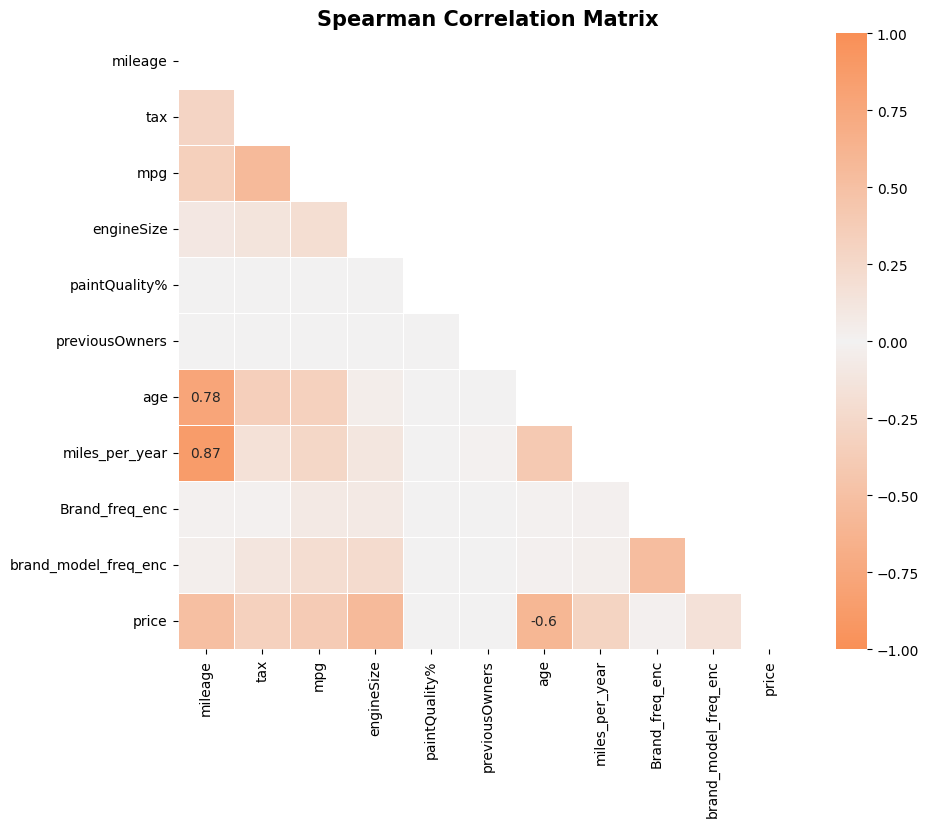

In [7]:
##### Spearman Correlation ####
cor = pd.concat([X_train_filtered, y_train], axis=1).corr(method='spearman').round(2)

# Create a custom diverging colormap based on orange tones
cmap = sns.diverging_palette(h_neg=30, h_pos=30, s=90, l=70, n=256, center="light", as_cmap=True) 

# Create a Mask to hide the upper triangle (to avoid redundancy)
mask = np.zeros_like(cor, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Only show values where absolute correlation is >= 0.6
mask_annot = np.absolute(cor.values) >= 0.6
annot = np.where(mask_annot, cor.values, np.full(cor.shape, ""))

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(
    data=cor,
    mask=mask,              # Hide the upper triangle
    cmap=cmap,              # Custom divergent color map
    annot=annot,            # Show annotations only if |value| >= 0.6
    fmt='s',                # Format annotations as strings
    vmin=-1, vmax=1, center=0, # Ensure the scale is from -1 to 1, centered at 0
    linewidths=0.5, 
)

plt.title('Spearman Correlation Matrix', fontsize=15, fontweight='bold')
plt.show()

By the rule of thumb, two variables are considered **redundant** when their absolute correlation is **greater than or equal to 0.8**. This is the case for **`mileage`** and **`miles_per_year`**, which is expected since `miles_per_year` was derived from `mileage`. We believe it would make more sense to **drop `mileage`**, as `miles_per_year` captures more information and `mileage` is also **highly correlated with `age`**, which could lead to **multicollinearity issues** if kept in the model, but we will **postpone this decision until the end of the feature selection stage**, after reviewing all method results.


In [8]:
# look for irrelevant features with |correlation| < 0.1
cor_with_target = cor[y_train.name]
low_corr_features = cor_with_target[abs(cor_with_target) < 0.1].drop(y_train.name, errors='ignore') # Correlation with itself is 1, so we drop it

if not low_corr_features.empty:
    print(f"Found {len(low_corr_features)} variables with absolute correlation < 0.1:")
    # Sort by absolute value to see the least correlated ones first
    print(low_corr_features.abs().sort_values())
else:
    print(f"No variables found with absolute correlation < 0.1 with the target")

Found 3 variables with absolute correlation < 0.1:
paintQuality%     0.00
previousOwners    0.00
Brand_freq_enc    0.02
Name: price, dtype: float64


By the rule of thumb, features with an absolute correlation below **0.1** with the target variable are considered **irrelevant**, as they provide little to no predictive information. In our case, **`paintQuality%`**, **`previousOwners`**, and **`Brand_freq_enc`** show correlations below this threshold, indicating that they are unlikely to contribute meaningfully to the model’s performance and can therefore be **discarded**; however, we will **leave this decision for the end of the feature selection process**, once we have the results from other methods.

##### **Statistical Hypothesis Testing** 

We performed this Chi-squared test in Part 1 of the notebook, and the results are shown here:<br>

The variables 'Brand' and 'model' are NOT independent (they are REDUNDANT)      
The variables 'Brand' and 'transmission' are NOT independent (they are REDUNDANT)     
The variables 'Brand' and 'fuelType' are NOT independent (they are REDUNDANT)     
The variables 'Brand' and 'brand_model' are NOT independent (they are REDUNDANT)      
The variables 'Brand' and 'hasDamage' are INDEPENDENT (they are NOT redundant)      
The variables 'model' and 'transmission' are NOT independent (they are REDUNDANT)      
The variables 'model' and 'fuelType' are NOT independent (they are REDUNDANT)         
The variables 'model' and 'brand_model' are NOT independent (they are REDUNDANT)       
The variables 'model' and 'hasDamage' are INDEPENDENT (they are NOT redundant)       
The variables 'transmission' and 'fuelType' are NOT independent (they are REDUNDANT)     
The variables 'transmission' and 'brand_model' are NOT independent (they are REDUNDANT)     
The variables 'transmission' and 'hasDamage' are INDEPENDENT (they are NOT redundant)     
The variables 'fuelType' and 'brand_model' are NOT independent (they are REDUNDANT)    
The variables 'fuelType' and 'hasDamage' are INDEPENDENT (they are NOT redundant)     
The variables 'brand_model' and 'hasDamage' are INDEPENDENT (they are NOT redundant)  <BR><BR><BR>

For all the remaining variables (note that *hasDamage* has already been discarded), they are redundant with each other. We decided **not to consider this test**, as it would result in keeping only a single categorical variable, potentially leading to the **loss of relevant information**.

<div style="background-color: #e5c120ff; padding:15px; border-radius:10px;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(255, 255, 255, 1);"><b>2.11.2 |  Wrapper Methods</b></span>
    </h1>
</div>

##### **RFE**

We applied **RFE (Recursive Feature Elimination)** based on the class example but extended it to work with both **Linear Regression** and **Random Forest** models, using **MAE** as the optimization criterion. The procedure iteratively removes the least important features, retraining the model each time to identify the subset of features that minimizes validation error. This approach allows us to balance model simplicity and predictive performance, ensuring that only the most relevant predictors are retained.


In [9]:
def find_optimal_features_rfe(model, X_train, y_train, X_val, y_val):
    nof_list = np.arange(1, len(X_train.columns) + 1)
    low_score = float('inf')  # Start with an infinite value to find the minimum
    nof = 0
    train_score_list = []
    val_score_list = []

    print(f"Running RFE with model: {model.__class__.__name__}")

    for n in nof_list:
        # Use clone to ensure the model is "clean" in each iteration
        estimator = clone(model)
        
        rfe = RFE(estimator=estimator, n_features_to_select=n)
        X_train_rfe = rfe.fit_transform(X_train, y_train)
        X_val_rfe = rfe.transform(X_val)

        # Train the final model with the selected features
        estimator.fit(X_train_rfe, y_train)
        
        # Store the MAE scores
        train_pred = estimator.predict(X_train_rfe)
        train_mae = mean_absolute_error(y_train, train_pred)
        train_score_list.append(train_mae)
        
        val_pred = estimator.predict(X_val_rfe)
        val_mae = mean_absolute_error(y_val, val_pred)
        val_score_list.append(val_mae)

        # Check for the lowest validation error
        if val_mae <= low_score:
            low_score = val_mae
            nof = n

    print(f"Optimal number of features: {nof} with a validation MAE of {low_score:.4f}")

    # Train the final model with the optimal number of features to get the final feature list
    final_rfe = RFE(estimator=clone(model), n_features_to_select=nof)
    final_rfe.fit(X_train, y_train)
    selected_features_names = X_train.columns[final_rfe.support_].tolist()

    # Return all useful results
    return {
        'optimal_n': nof,
        'best_score': low_score,
        'selected_features': selected_features_names,
        'train_scores': train_score_list,
        'val_scores': val_score_list
    }

In [10]:
# RFE with Linear Regression optimized for MAE
lr_model = LinearRegression()
rfe_results_lr = find_optimal_features_rfe(lr_model, X_train, y_train, X_val, y_val)
print(f"Selected features ({rfe_results_lr['optimal_n']}): {rfe_results_lr['selected_features']}\n")


# RFE with RandomForest Regressor optimized for MAE
rf_model = RandomForestRegressor(n_estimators=50, random_state=37, n_jobs=-1)
rfe_results_rf = find_optimal_features_rfe(rf_model, X_train, y_train, X_val, y_val)
print(f"Selected features ({rfe_results_rf['optimal_n']}): {rfe_results_rf['selected_features']}")

Running RFE with model: LinearRegression
Optimal number of features: 16 with a validation MAE of 3535.9938
Selected features (16): ['mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'age', 'miles_per_year', 'Brand_freq_enc', 'brand_model_freq_enc', 'transmission_manual', 'transmission_semi auto', 'transmission_unknown', 'fuelType_hybrid', 'fuelType_petrol', 'fuelType_unknown']

Running RFE with model: RandomForestRegressor
Optimal number of features: 7 with a validation MAE of 1454.6486
Selected features (7): ['mileage', 'mpg', 'engineSize', 'age', 'Brand_freq_enc', 'brand_model_freq_enc', 'transmission_manual']


apagar

<div style="background-color: #e5c120ff; padding:15px; border-radius:10px;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(255, 255, 255, 1);"><b>2.11.3 |  Embedded Methods</b></span>
    </h1>
</div>


- **Regularization methods**: These methods add a penalty term to the model's loss function that discourages the model from using too many features. Examples include Lasso (L1 regularization - which mmakes the weights of unimportant variables actually reach 0) and Ridge (L2 regularization - whose weights assymptotically tend to 0 - but do not reach it).

- **Tree-based methods** NA 

In [11]:
# ---  Lasso Regularization (L1) ---
lasso_model = Lasso(alpha=1.0, random_state=37, max_iter=10000)

# Train the model using only the training data
lasso_model.fit(X_train, y_train)

# Get the coefficients and select features with non-zero coefficients
lasso_coefs = pd.Series(lasso_model.coef_, index=X_train.columns)
selected_features_lasso = lasso_coefs[lasso_coefs != 0].index.tolist()

print(f"\nNumber of features selected by Lasso: {len(selected_features_lasso)}")
print(f"Selected Features: {selected_features_lasso}")

# Show the most important features (based on coefficient magnitude)
print("\nFeature Importance (Lasso):")
print(abs(lasso_coefs).sort_values(ascending=False).head(20))  # Show the 20 most important


# --- Ridge Regularization (L2) with Fixed Alpha ---

print("\n\n" + "="*50)

# Instantiate the model with a fixed alpha
ridge_model = Ridge(alpha=1.0, random_state=37)

# Train the model using only the training data
ridge_model.fit(X_train, y_train)

# Get the coefficients. Ridge does not zero out coefficients,
# but their magnitude indicates the feature’s importance in the model.
ridge_coefs = pd.Series(ridge_model.coef_, index=X_train.columns)

print("\nFeature Importance (Ridge coefficient magnitudes):")
# Since Ridge doesn’t perform feature selection (doesn’t zero coefficients),
# we display all features ordered by their importance
print(abs(ridge_coefs).sort_values(ascending=False).head(20))  # Show the 20 most important


Number of features selected by Lasso: 16
Selected Features: ['mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'age', 'miles_per_year', 'Brand_freq_enc', 'brand_model_freq_enc', 'transmission_manual', 'transmission_semi auto', 'transmission_unknown', 'fuelType_hybrid', 'fuelType_petrol', 'fuelType_unknown']

Feature Importance (Lasso):
engineSize                7545.178553
age                       4798.995551
transmission_manual       3713.157979
transmission_unknown      1886.698678
fuelType_hybrid           1787.417716
mileage                   1505.499347
transmission_semi auto    1100.037584
mpg                        851.721484
Brand_freq_enc             612.191209
miles_per_year             577.630497
fuelType_unknown           444.286256
fuelType_petrol            427.387226
brand_model_freq_enc       203.841025
paintQuality%               90.109099
tax                         69.163427
previousOwners              21.753655
dtype: float64



Feature Imp

Nós decidimos ficar com as variáveis que fossem recomendadas por pelo menos 3 dos 4 métodos usados (Spearman, RFE com Regressão Logística, RFE com SVM e Lasso). A tabela seguinte resume as decisões tomadas para cada variável:


| Predictor            | Spearman  |RFE LR   | RFE RF   | aaaa     | Lasso    | What to do? | 
| ---                  | ---       |  ---    |   ---    |    ---   |  ---     |   ---       |
| mileage              |  D?       | Keep    | Keep?    |Keep      | Keep     |             |  
| tax                  | Keep      | Keep    |          |          |          |             |
| mpg                  | Keep      | Keep    |          |          |          |             |
| engineSize           | Keep      | Keep    |          |          |          |             |
| paintQuality%        | Discard   | Keep    |          |          |          |             |
| previousOwners       | Discard   | Keep    |          |          |          |             |
| age                  | Keep      | Keep    |          |          |          |             |
| miles_per_year       | Discard   | Keep    |          |          |          |             |
| Brand_freq_enc       | Discard   | Keep    |          |          |          |             |
| brand_model_freq_enc | Keep      | Keep    |          |          |          |             |
|transmission_manual   |   -       | Keep    |          |          |          |             |
|transmission_semi auto|-          | Keep    |          |          |          |             |
|transmission_unknown  |-          | Keep    |          |          |          |             |
|fuelType_hybrid       |-          | Keep    |          |          |          |             |
|fuelType_petrol       |-          | Keep    |          |          |          |             |
|fuelType_unknown      |-          | Keep    |          |          |          |             |
<hr>

# <span style="color: #ffffff;">3 | Regression Benchmarking</span>

<div style="background-color:#e5c120ff; padding:15px; border-radius:10px; 
            box-shadow: 0px 4px 12px rgba(227, 167, 108, 1);">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: #644712ff;"><b>3 | Regression Benchmarking</b></span>
    </h1>
</div>


We are dealing with a **supervised regression problem**, as the target variable `price` is **numerical and continuous**. The goal is to train a model that learns the relationship between car characteristics (`Brand`, `model`, `mileage`, `year`, ...) and `price`, allowing it to predict the value of unseen cars.

Both **linear models** (e.g., *Linear Regression*, *Ridge*, *ElasticNet*) and **non-linear models** (e.g., *KNN*, *Decision Tree*, *SVR*) can be applied. In this problem, we focus on predicting the **median price** because car prices often include **outliers or extreme values** that could skew mean-based predictions. The **median is robust** to such extremes, providing more reliable predictions for typical cars.

For this reason, **median-based loss functions** such as *MAE* (Mean Absolute Error) or *Pinball Loss* with α = 0.5 are most appropriate, as they are **strictly consistent for the median functional**. We will use *MAE* as the primary metric, in line with the Kaggle competition, while monitoring other metrics to track overall model performance.

#APAGAR

he Pinball Loss (also known as Quantile Loss) is a generalization of the absolute error that allows a model to predict conditional quantiles of the target variable, rather than just the mean.
It introduces an asymmetry controlled by the quantile parameter α (alpha), where α ∈ [0, 1]:

When α = 0.5, the loss becomes symmetric, corresponding to the median — effectively equivalent to the MAE objective.


In [ ]:
# EVALUATION FUNCTION 
def evaluate_model(model, X_train, y_train, X_val, y_val):
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Calculate metrics
    scores = {
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Val MAE': mean_absolute_error(y_val, y_val_pred),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Val RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'Train Pinball (α=0.5)': mean_pinball_loss(y_train, y_train_pred, alpha=0.5),
        'Val Pinball (α=0.5)': mean_pinball_loss(y_val, y_val_pred, alpha=0.5)
    }
    return scores

# MODELS AND HYPERPARAMETER GRIDS
models_and_grids = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {} # Here we have no hyperparameters to tune
    },
    "ElasticNet": {
        "model": ElasticNet(random_state=37),
        "params": {
            'alpha': [0.1, 1.0, 10.0],   # Regularization strength
            'l1_ratio': [0.1, 0.5, 0.9]  # Mix between L1 and L2
        }
    },
    "SVR": {
        "model": SVR(),
        "params": {
            'kernel': ['rbf'],
            'C': [1, 10, 100],      # Regularization parameter
            'gamma': ['scale', 'auto'] # Kernel coefficient
        }
    },
    "Decision Tree": {
        "model": DecisionTreeRegressor(random_state=37),
        "params": {
            'max_depth': [5, 10, None], # Max depth to control overfitting
            'min_samples_leaf': [2, 5]  # Min samples per leaf
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=37, n_jobs=-1),
        "params": {
            'n_estimators': [100],      # Number of trees
            'max_depth': [10, 20],      # Max depth of trees
            'min_samples_leaf': [2, 4, 6] # Min samples per leaf
        }
    },
    "K-Neighbors": {
        "model": KNeighborsRegressor(n_jobs=-1),
        "params": {
            'n_neighbors': [3, 5, 7],   # Number of neighbors
            'weights': ['uniform', 'distance'] # Weight function
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(random_state=37),        
        "params": {
            'learning_rate': [0.1],
            'max_depth': [3,7],
            'min_samples_leaf': [3,5],
            'n_estimators': [200],
            'subsample': [1.0, 0.8]
        }
    }
}


# MODEL TRAINING AND EVALUATION LOOP
results_list = []

# Iterate over each model defined in the dictionary
for model_name, config in models_and_grids.items():
    print(f"--- Processing model: {model_name} ---")
    param_grid = ParameterGrid(config['params'])
    best_model_results = None
    best_val_mae = float('inf')

    # Handle Linear Regression which has no grid
    if not list(param_grid):
        model = config['model']
        # Fit the model directly using X_train
        model.fit(X_train, y_train)
        scores = evaluate_model(model, X_train, y_train, X_val, y_val)
        best_model_results = {
            'Model': model_name,
            'Best Params': '{}',
            **scores
        }
    else:
        # Iterate over each combination of hyperparameters
        for params in param_grid:
            model = config['model']
            model.set_params(**params)
            
            # Fit the model directly using X_train
            model.fit(X_train, y_train)
            
            # Evaluate the model using the new evaluation function
            scores = evaluate_model(model, X_train, y_train, X_val, y_val)
            
            print(f"  Params: {params} -> Val MAE: {scores['Val MAE']:.4f}")
            
            # Store the best result based on validation MAE
            if scores['Val MAE'] < best_val_mae:
                best_val_mae = scores['Val MAE']
                best_model_results = {
                    'Model': model_name,
                    'Best Params': str(params),
                    **scores
                }
    
    results_list.append(best_model_results)
    print(f"Best validation MAE for {model_name}: {best_val_mae:.4f}\n")


# GET FINAL RESULTS
results_df = pd.DataFrame(results_list)

# Sort the results by validation MAE
results_df = results_df.sort_values(by='Val MAE', ascending=True)

# Reorder columns for better readability with the new metrics
columns_order = [
    'Model', 'Val MAE', 'Train MAE', 'Val RMSE', 'Train RMSE', 
    'Val Pinball (α=0.5)', 'Train Pinball (α=0.5)', 'Best Params'
]
results_df = results_df[columns_order]
display(results_df)

DIZER QUE DEVEMOS ESCOLHER SVR PORQUE TEM MENOS OVERFIT MAS COMO A ORDEM CONTA VAMOS SEGUIR COM RANDOM FOREST DANDO A CADA MODELO AS MESMAS HIPÓTESES DE SER MELHOR, E É O MELHOR PARA ESTA PARTIÇÃO DE DADOS

APAGAR: DIZER PORQUÊ QUE UM MODELO É MELHOR COM OUTRO EM TERMOS DE PERFORMANCE

In [ ]:
print("Combining training and validation datasets...")
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

print(f"Final training set dimensions (X): {X_train_full.shape}")
print(f"Final training set dimensions (y): {y_train_full.shape}")

# --- 2. Train the Final Model with the Best Hyperparameters ---
print("\nTraining the final Random Forest model...")
best_params = {
    'n_estimators': 100, 'max_depth': 20, 'min_samples_leaf': 2,
    'random_state': 37, 'n_jobs': -1
}
final_model = RandomForestRegressor(**best_params)
final_model.fit(X_train_full, y_train_full)
print("Final model trained successfully!")

# --- 3. Make Predictions on the Test Set ---
print("\nMaking predictions on the test set...")
test_predictions = final_model.predict(X_test)

# --- 4. Create and Export the Submission File ---

# <<< CHANGE 3: The submission logic now works perfectly. >>>
# X_test.index contains the 'carID' as desired.
print("Creating the submission file...")
submission_df = pd.DataFrame({
    'carID': X_test.index,
    'price': test_predictions
})

# Export to a CSV file without the DataFrame index
submission_df.to_csv("./project_data/Group37_Version1.csv", index=False)
print("\nSubmission file 'Group37_Version1.csv' exported successfully!")
print("First 5 rows of the submission file:")
print(submission_df.head())

In [ ]:
# # --- 1. Combinar os dados de treino e validação ---

# print("A combinar os conjuntos de dados de treino e validação...")
# # Combinar as features (X)
# X_train_full = pd.concat([X_train, X_val], ignore_index=False)

# # Combinar os alvos (y)
# y_train_full = pd.concat([y_train, y_val], ignore_index=False)

# print(f"Dimensão do novo conjunto de treino (X): {X_train_full.shape}")
# print(f"Dimensão do novo conjunto de treino (y): {y_train_full.shape}")


# # --- 2. Treinar o Modelo Final com os Melhores Hiperparâmetros ---

# print("\nA treinar o modelo final de Random Forest...")

# # Definir os melhores hiperparâmetros encontrados na fase anterior
# # Assumindo n_estimators=100, que é um valor padrão robusto
# best_params = {
#     'n_estimators': 100,
#     'max_depth': 20,
#     'min_samples_leaf': 2,
#     'random_state': 37,  # Usar um random_state para reprodutibilidade
#     'n_jobs': -1         # Usar todos os processadores disponíveis
# }

# # Instanciar o modelo
# final_model = RandomForestRegressor(**best_params)

# # Treinar o modelo com todos os dados disponíveis
# final_model.fit(X_train_full, y_train_full)

# print("Modelo final treinado com sucesso!")


# # --- 3. Fazer Previsões no Conjunto de Teste ---

# print("\nA fazer previsões no conjunto de teste...")
# test_predictions = final_model.predict(X_test)


# # --- 4. Criar e Exportar o Ficheiro de Submissão ---

# print("A criar o ficheiro de submissão...")

# # Criar um DataFrame com o formato solicitado
# # O índice de X_test é usado como 'carID'
# submission_df = pd.DataFrame({
#     'carID': X_test.index,
#     'price': test_predictions
# })

# # Exportar para um ficheiro CSV sem incluir o índice do DataFrame no ficheiro
# submission_df.to_csv("./project_data/Group37_Version1.csv", index=False)


A combinar os conjuntos de dados de treino e validação...
Dimensão do novo conjunto de treino (X): (75954, 16)
Dimensão do novo conjunto de treino (y): (75954,)

A treinar o modelo final de Random Forest...
Modelo final treinado com sucesso!

A fazer previsões no conjunto de teste...
A criar o ficheiro de submissão...


NameError: name 'file_path' is not defined

In [ ]:

# print(f"\nFicheiro exportado com sucesso!")
# print("Primeiras 5 linhas do ficheiro de submissão:")
# print(submission_df.head())


Ficheiro exportado com sucesso!
Primeiras 5 linhas do ficheiro de submissão:
   carID         price
0      0  21698.912321
1      1  21420.602285
2      2  13282.123121
3      3  16726.311714
4      4  24298.183921
